# 1.1 Face detection

## Frame extraction and face detection

The extraction and analysis of features from the 42 minute video was executed outside this notebook, using two python scripts, in 'face_detection' folder:
- 'extract_frames.py', to chop the video into frames - one per second - and
- 'detect_faces.py', to identify faces in those frames.

The first script was used once and the generated JPEG images are present in 'frames' folder.

The second was used twice, applying two different Haar feature-based cascade classifiers - frontal face and face profile - available in OpenCV by default but copied to 'haarcascade' folder. 

These operations generated two collections of images with the identified faces - in 'detected_haar_profile' and 'detected_haar_frontal' folders. Two logfiles -  'faces_haar_profile.log' and 'faces_haar_frontal.log' - were also generated, listing the number of faces detected in each frame.

Althought the sum of faces detected by both classifiers is not very far from the absolute number of faces an human would detect in the image, some faces are detected twice. This fact uncovered potential for improvement of face detection using Haar-cascade classifiers without substantial effort.

Haar-cascade detection with frontal face classifier | Haar-cascade detection with face profile classifier
- | -
![Detection with frontal classifier](face_detection/detected_haar_frontal/frame373_22.jpg) | ![Detection with profile classifier](face_detection/detected_haar_profile/frame373_9.jpg)

A possible algorithm to remove duplicates would compare every bounding box and remove duplicates by assessing which would have overlapping corners - considering a threshold of proximity between equivalent corners.

Since version 3.3 OpenCV makes available deep neural networks for classification that look very promising but the tests made suggest more/better training would be necessary for the model used for face detection.

## 1. What’s the percentage of time a face is shown in the video?

To answer this question we will have to check how many of the frames have at least one face detected.
Let us start by importing libraries necessary for our calculations.

In [290]:
# import the necessary libraries (nicely)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import math

%matplotlib inline


Next, we have to load our log files into dataframes.

In [193]:
df_frontal = pd.read_csv('face_detection/detected_haar_frontal/faces_haar_frontal.log', sep=",", header=None)
df_frontal.columns = ['frame', 'frontal_count']
df_profile = pd.read_csv('face_detection/detected_haar_profile/faces_haar_profile.log', sep=",", header=None)
df_profile.columns = ['frame', 'profile_count']

Let us merge both dataframes in a new dataframe using common key 'frame'. We will (very loosely) assume that the number of faces in a frame is the sum of detected faces by both classifiers.

In [194]:
df_faces = pd.merge(df_frontal, df_profile, on='frame')
df_faces['faces'] = df_faces.frontal_count + df_faces.profile_count
df_faces['seconds'] = df_faces['frame'].str[14:-4].astype(int)
def seconds2timedelta(secs):
    return datetime.timedelta(seconds=secs)
df_faces['time'] = df_faces['seconds'].apply(lambda x: seconds2timedelta(x))
df_faces = df_faces.sort_values(by=['seconds'])
df_faces.head()

,frame,frontal_count,profile_count,faces,seconds,time
1892,./frames/frame0.jpg,0,0,0,0,00:00:00
2076,./frames/frame1.jpg,0,0,0,1,00:00:01
1862,./frames/frame2.jpg,1,0,1,2,00:00:02
2077,./frames/frame3.jpg,0,0,0,3,00:00:03
434,./frames/frame4.jpg,0,0,0,4,00:00:04


Both logs have 2520 entries - 42 minutes * 60 seconds.

In [195]:
total_seconds = df_faces.count()
print total_seconds

frame            2520
frontal_count    2520
profile_count    2520
faces            2520
seconds          2520
time             2520
dtype: int64


The number of frames (seconds) with (at least) a face is

In [196]:
face_seconds = df_faces.loc[df_faces['faces'] > 0].count()
print face_seconds

frame            2147
frontal_count    2147
profile_count    2147
faces            2147
seconds          2147
time             2147
dtype: int64


We can now calculate the percentage of frames (seconds) have at least a face showing/detected.

In [197]:
face_percentage = face_seconds / total_seconds * 100
print face_percentage

frame            85.198413
frontal_count    85.198413
profile_count    85.198413
faces            85.198413
seconds          85.198413
time             85.198413
dtype: float64


A face is shown __over 85%__ of time of the video.

## 2. What is the average amount of faces in a frame?

Adding every detected face by the number of frames will get us the desired result.

In [198]:
avg_faces_frame = df_faces['faces'].sum() / df_faces.count()
print avg_faces_frame

frame            2.328571
frontal_count    2.328571
profile_count    2.328571
faces            2.328571
seconds          2.328571
time             2.328571
dtype: float64


On average, there are __2.33__ faces in a frame.

## 3. What is the average amount of faces in a frame with at least one face?

In [199]:
avg_faces_frame_with_face = df_faces.loc[df_faces['faces'] > 0]['faces'].sum() / df_faces.loc[df_faces['faces'] > 0].count()
print avg_faces_frame_with_face

frame            2.733116
frontal_count    2.733116
profile_count    2.733116
faces            2.733116
seconds          2.733116
time             2.733116
dtype: float64


There are __2.73__ faces in a frame with detected faces, on average.

## 4. How does the number of faces evolve during the show?

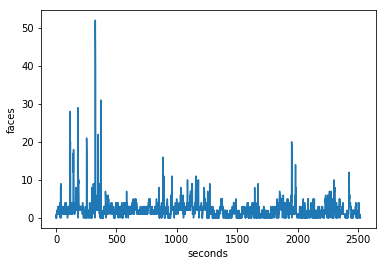

In [200]:
sns.lineplot(x=df_faces['seconds'],y=df_faces['faces'])

# 1.2 OCR

## 1. Extract the text from the footer of each frame, when the background of the footer is blue.

The extraction of text from each frame footer - where existent - was made outside this notebook using a python script - 'ocr_subtitles.py' - in 'ocr' folder and results compiled in 'ocr.log'.

OCR using Tesseract open source library is not fault proof and this exercise would have benefited from further refinement to grasp valid text for subtitles in this particular show.

## 2. Write the subtitles in file with the SubRip format.

Let us load the extracted subtitles into a dataframe for futher processing.

In [232]:
df_ocr = pd.read_csv('ocr/ocr.log', sep=",", header=None)
df_ocr.columns = ['frame', 'ocr_text']

In [233]:
df_ocr.head()

,frame,ocr_text
0,../face_detection/frames/frame1488.jpg,I POUPMAS 2019
1,../face_detection/frames/frame1652.jpg,NaN
2,../face_detection/frames/frame1369.jpg,NaN
3,../face_detection/frames/frame1092.jpg,NOVO PRESIDENTE DO BRASIL
4,../face_detection/frames/frame115.jpg,u I PBOHSONMIO PRESIDENTE


To write the subtitles in file with SubRip format it will be necessary to have the subtitles properly sequenced.

In [251]:
df_ocr['seconds'] = df_ocr['frame'].str[30:-4].astype(int)
df_ocr = df_ocr.sort_values(by=['seconds'])
def seconds2timedelta(secs):
    return datetime.timedelta(seconds=secs)
df_ocr['time'] = df_ocr['seconds'].apply(lambda x: seconds2timedelta(x))
df_ocr = df_ocr.sort_values(by=['seconds'])
df_ocr.loc[df_ocr['ocr_text'] > 0]

,frame,ocr_text,seconds,time
1705,../face_detection/frames/frame52.jpg,BOLSONARO PRESIDENTE,52,00:00:52
1649,../face_detection/frames/frame53.jpg,BOLSONARO PRESIDENTE,53,00:00:53
1513,../face_detection/frames/frame54.jpg,BOLSONARO PRESIDENTE,54,00:00:54
1954,../face_detection/frames/frame58.jpg,I I BOLSONARO PRESIDENIE,58,00:00:58
1096,../face_detection/frames/frame59.jpg,I I r msomo msmam,59,00:00:59
1970,../face_detection/frames/frame61.jpg,BOLSONARO PRESIDENTE,61,00:01:01
422,../face_detection/frames/frame63.jpg,BOLSONARO PRESIDENTE,63,00:01:03
2071,../face_detection/frames/frame67.jpg,I a ausomo mesm m,67,00:01:07
1969,../face_detection/frames/frame69.jpg,f I F BOLSONABO PRESIDENT,69,00:01:09
1081,../face_detection/frames/frame70.jpg,I comma msmnm,70,00:01:10


As one can comprehend, some of the extracted text has small errors that will break the continuity of the SubRip format. This could have been minimized by grouping subtitles that are temporally close and/or adjacent - and have similar structure/length. From these groups, some candidates could have meaningful and correct text - even repeated among different candidates; this validated text would make the actual subtitle for the entire time slot of similar subtitles.

Without having developed the algorithm that far, let us generate the SubRip text file disregarding these subtleties.

In [321]:
filename = 'ocr/subrip.txt'
f = open(filename, 'w+')
sub = ''
start = 0
stop = 0
idx = 0
for x in range(0, 2520):
    new_sub = df_ocr.loc[df_ocr['seconds'] == x, 'ocr_text'].tolist()[0]
    print 'seconds: ' + str(x)
    print 'new_sub: ' + str(new_sub)
    # if new subtitle is different than previous subtitle
    if new_sub != sub:
        # if previous subtitle was not the initial auxiliary text ('')
        # and if previous subtitle was not null
        # i.e.: the previous subtitle is worth recording
        if sub != '' and str(sub) != 'nan':
            # set stop time for previous subtitle
            stop = str(df_ocr.loc[df_ocr['seconds'] == (x - 1) , 'time'].tolist()[0]) + ',999'
            stop = stop.replace('0 days ', '')
            
            # write subrip format in text file
            f.write(str(idx) + '\n')
            f.write(start + ' -> ' + stop + '\n')
            f.write(str(sub) + '\n')
                        
#             print 'idx: ' + str(idx)
#             print 'start: ' + start
#             print 'stop: ' + stop
#             print 'sub: ' + str(sub)

        # if new subtitle is not null
        if str(new_sub) != 'nan':
            # increment index for coming worthwhile subtitle
            idx += 1
            # set start time for coming file entry
            start = str(df_ocr.loc[df_ocr['seconds'] == x, 'time'].tolist()[0]) + ',000'
            start = start.replace('0 days ', '')
    
    # future previous subtitle equals current subtitle
    sub = new_sub
        
f.close()

seconds: 0
new_sub: nan
seconds: 1
new_sub: nan
seconds: 2
new_sub: nan
seconds: 3
new_sub: nan
seconds: 4
new_sub: nan
seconds: 5
new_sub: nan
seconds: 6
new_sub: nan
seconds: 7
new_sub: nan
seconds: 8
new_sub: nan
seconds: 9
new_sub: nan
seconds: 10
new_sub: nan
seconds: 11
new_sub: nan
seconds: 12
new_sub: nan
seconds: 13
new_sub: nan
seconds: 14
new_sub: nan
seconds: 15
new_sub: nan
seconds: 16
new_sub: nan
seconds: 17
new_sub: nan
seconds: 18
new_sub: nan
seconds: 19
new_sub: nan
seconds: 20
new_sub: nan
seconds: 21
new_sub: nan
seconds: 22
new_sub: nan
seconds: 23
new_sub: nan
seconds: 24
new_sub: nan
seconds: 25
new_sub: nan
seconds: 26
new_sub: nan
seconds: 27
new_sub: nan
seconds: 28
new_sub: nan
seconds: 29
new_sub: nan
seconds: 30
new_sub: nan
seconds: 31
new_sub: nan
seconds: 32
new_sub: nan
seconds: 33
new_sub: nan
seconds: 34
new_sub: nan
seconds: 35
new_sub: nan
seconds: 36
new_sub: nan
seconds: 37
new_sub: nan
seconds: 38
new_sub: nan
seconds: 39
new_sub: nan
seconds: 4

idx: 61
start: 00:02:24,000
stop: 00:02:24,999
sub: w    BOLSONARO PRESIDENTE
seconds: 146
new_sub: adisomao Passmsm
idx: 62
start: 00:02:25,000
stop: 00:02:25,999
sub: BOLSONARO PRESIDENTE
seconds: 147
new_sub: I   BOLSONARO PRESiDENTE
idx: 63
start: 00:02:26,000
stop: 00:02:26,999
sub: adisomao Passmsm
seconds: 148
new_sub: BOLSONARO PRESIlJ ENTE
idx: 64
start: 00:02:27,000
stop: 00:02:27,999
sub: I   BOLSONARO PRESiDENTE
seconds: 149
new_sub: l I BOLSONARO PRESIDENT
idx: 65
start: 00:02:28,000
stop: 00:02:28,999
sub: BOLSONARO PRESIlJ ENTE
seconds: 150
new_sub: I I  BOLSONABO PRESIDENTE
idx: 66
start: 00:02:29,000
stop: 00:02:29,999
sub: l I BOLSONARO PRESIDENT
seconds: 151
new_sub: l l BOLSONARO PRESIDENTE
idx: 67
start: 00:02:30,000
stop: 00:02:30,999
sub: I I  BOLSONABO PRESIDENTE
seconds: 152
new_sub: I   BOLSONARO PRESIDENTS
idx: 68
start: 00:02:31,000
stop: 00:02:31,999
sub: l l BOLSONARO PRESIDENTE
seconds: 153
new_sub: v    I BOLSONARO PRESIDENIE
idx: 69
start: 00:02:32,000


seconds: 272
new_sub: I n   f y  SEGUMNQA IOMADA DE POSSE
idx: 136
start: 00:04:31,000
stop: 00:04:31,999
sub: 1       SEGUMNCI TOMADA DE POSSE I
seconds: 273
new_sub: k   4   4       SEGUMNQA TOMADA DE POSSE
idx: 137
start: 00:04:32,000
stop: 00:04:32,999
sub: I n   f y  SEGUMNQA IOMADA DE POSSE
seconds: 274
new_sub: kt Gunmen 10mm 0  POSSE
idx: 138
start: 00:04:33,000
stop: 00:04:33,999
sub: k   4   4       SEGUMNQA TOMADA DE POSSE
seconds: 275
new_sub: SEGUHANCA IOMADA DE POSS
idx: 139
start: 00:04:34,000
stop: 00:04:34,999
sub: kt Gunmen 10mm 0  POSSE
seconds: 276
new_sub: GUM    IOMADA DE POSSE
idx: 140
start: 00:04:35,000
stop: 00:04:35,999
sub: SEGUHANCA IOMADA DE POSS
seconds: 277
new_sub: SEGUMNGA TOMADA DE POSS
idx: 141
start: 00:04:36,000
stop: 00:04:36,999
sub: GUM    IOMADA DE POSSE
seconds: 278
new_sub: Ii SEGUMNQI IOMADA DE POSSE
idx: 142
start: 00:04:37,000
stop: 00:04:37,999
sub: SEGUMNGA TOMADA DE POSS
seconds: 279
new_sub: nan
idx: 143
start: 00:04:38,000
stop: 00:04

seconds: 355
new_sub: M  NOVO PRESIDENTE oo anAsIL 3
idx: 218
start: 00:05:54,000
stop: 00:05:54,999
sub: an               NOVO PRESIDENTS DO BRASIL g
seconds: 356
new_sub: 41 34     uovo Passlbsms oo snAsIL 3
idx: 219
start: 00:05:55,000
stop: 00:05:55,999
sub: M  NOVO PRESIDENTE oo anAsIL 3
seconds: 357
new_sub: L   M NOVO PRESIDENT  DO BRASIL I
idx: 220
start: 00:05:56,000
stop: 00:05:56,999
sub: 41 34     uovo Passlbsms oo snAsIL 3
seconds: 358
new_sub: G I uovo PRESIDENTEDOBMSIL 1
idx: 221
start: 00:05:57,000
stop: 00:05:57,999
sub: L   M NOVO PRESIDENT  DO BRASIL I
seconds: 359
new_sub: NOVO PRESIDENTS DO BRASIL
idx: 222
start: 00:05:58,000
stop: 00:05:58,999
sub: G I uovo PRESIDENTEDOBMSIL 1
seconds: 360
new_sub: nan
idx: 223
start: 00:05:59,000
stop: 00:05:59,999
sub: NOVO PRESIDENTS DO BRASIL
seconds: 361
new_sub: I  NOVO PRESIDEN I E DO BRASIL
seconds: 362
new_sub: nan
idx: 224
start: 00:06:01,000
stop: 00:06:01,999
sub: I  NOVO PRESIDEN I E DO BRASIL
seconds: 363
new_sub: na

seconds: 511
new_sub: nan
idx: 267
start: 00:08:30,000
stop: 00:08:30,999
sub: NOVO PRESIDENTE DO BRASIL
seconds: 512
new_sub: nan
seconds: 513
new_sub: NOVO PRESIDENTE DO BRASIL
seconds: 514
new_sub: NOVO PRESIDENTE D0 BRASIL
idx: 268
start: 00:08:33,000
stop: 00:08:33,999
sub: NOVO PRESIDENTE DO BRASIL
seconds: 515
new_sub: NOVO PRESIDENTE DO BRASIL
idx: 269
start: 00:08:34,000
stop: 00:08:34,999
sub: NOVO PRESIDENTE D0 BRASIL
seconds: 516
new_sub: NOVO PRESIDENTE DO BRASIL
seconds: 517
new_sub: nan
idx: 270
start: 00:08:35,000
stop: 00:08:36,999
sub: NOVO PRESIDENTE DO BRASIL
seconds: 518
new_sub: nan
seconds: 519
new_sub: nan
seconds: 520
new_sub: nan
seconds: 521
new_sub: NOVO PRESIDENTE D0 BRASIL
seconds: 522
new_sub: NOVO PRESIDENTE DO BRASIL
idx: 271
start: 00:08:41,000
stop: 00:08:41,999
sub: NOVO PRESIDENTE D0 BRASIL
seconds: 523
new_sub: NOVO PRESIDENTE DO BRASIL
seconds: 524
new_sub: nan
idx: 272
start: 00:08:42,000
stop: 00:08:43,999
sub: NOVO PRESIDENTE DO BRASIL
seconds:

seconds: 807
new_sub: nan
seconds: 808
new_sub: nan
seconds: 809
new_sub: nan
seconds: 810
new_sub: nan
seconds: 811
new_sub: nan
seconds: 812
new_sub: nan
seconds: 813
new_sub: nan
seconds: 814
new_sub: nan
seconds: 815
new_sub: nan
seconds: 816
new_sub: nan
seconds: 817
new_sub: nan
seconds: 818
new_sub: nan
seconds: 819
new_sub: nan
seconds: 820
new_sub: nan
seconds: 821
new_sub: nan
seconds: 822
new_sub: nan
seconds: 823
new_sub: nan
seconds: 824
new_sub: nan
seconds: 825
new_sub: nan
seconds: 826
new_sub: nan
seconds: 827
new_sub: nan
seconds: 828
new_sub: nan
seconds: 829
new_sub: nan
seconds: 830
new_sub: nan
seconds: 831
new_sub: nan
seconds: 832
new_sub: nan
seconds: 833
new_sub: nan
seconds: 834
new_sub: nan
seconds: 835
new_sub: nan
seconds: 836
new_sub: nan
seconds: 837
new_sub: nan
seconds: 838
new_sub: nan
seconds: 839
new_sub: nan
seconds: 840
new_sub: nan
seconds: 841
new_sub: nan
seconds: 842
new_sub: nan
seconds: 843
new_sub: nan
seconds: 844
new_sub: nan
seconds: 845

seconds: 954
new_sub: nan
seconds: 955
new_sub: nan
seconds: 956
new_sub: nan
seconds: 957
new_sub: nan
seconds: 958
new_sub: nan
seconds: 959
new_sub: nan
seconds: 960
new_sub: nan
seconds: 961
new_sub: nan
seconds: 962
new_sub: nan
seconds: 963
new_sub: nan
seconds: 964
new_sub: nan
seconds: 965
new_sub: nan
seconds: 966
new_sub: nan
seconds: 967
new_sub: nan
seconds: 968
new_sub: nan
seconds: 969
new_sub: nan
seconds: 970
new_sub: nan
seconds: 971
new_sub: nan
seconds: 972
new_sub: nan
seconds: 973
new_sub: nan
seconds: 974
new_sub: nan
seconds: 975
new_sub: nan
seconds: 976
new_sub: nan
seconds: 977
new_sub: nan
seconds: 978
new_sub: nan
seconds: 979
new_sub: nan
seconds: 980
new_sub: nan
seconds: 981
new_sub: nan
seconds: 982
new_sub: nan
seconds: 983
new_sub: nan
seconds: 984
new_sub: nan
seconds: 985
new_sub: nan
seconds: 986
new_sub: nan
seconds: 987
new_sub: nan
seconds: 988
new_sub: nan
seconds: 989
new_sub: nan
seconds: 990
new_sub: nan
seconds: 991
new_sub: nan
seconds: 992

new_sub: NOVO IKESIDENTE DO BHASIL
idx: 420
start: 00:18:00,000
stop: 00:18:00,999
sub: NOVO Sis   mm  no BRASIL
seconds: 1082
new_sub: NOVO PRESIDENTE DO BRASII
idx: 421
start: 00:18:01,000
stop: 00:18:01,999
sub: NOVO IKESIDENTE DO BHASIL
seconds: 1083
new_sub: NOVO    lm     no BRASIL
idx: 422
start: 00:18:02,000
stop: 00:18:02,999
sub: NOVO PRESIDENTE DO BRASII
seconds: 1084
new_sub: NOVO    ESIDENTE DO BRASIL
idx: 423
start: 00:18:03,000
stop: 00:18:03,999
sub: NOVO    lm     no BRASIL
seconds: 1085
new_sub: NOVO     SIDENTE DO BRASIL
idx: 424
start: 00:18:04,000
stop: 00:18:04,999
sub: NOVO    ESIDENTE DO BRASIL
seconds: 1086
new_sub: NOVO PRESIDENTE DO BRASIL
idx: 425
start: 00:18:05,000
stop: 00:18:05,999
sub: NOVO     SIDENTE DO BRASIL
seconds: 1087
new_sub: NOVO PRESIDENT  00 BHASIL
idx: 426
start: 00:18:06,000
stop: 00:18:06,999
sub: NOVO PRESIDENTE DO BRASIL
seconds: 1088
new_sub: NOVO PRESIDENTE DO BRASIL
idx: 427
start: 00:18:07,000
stop: 00:18:07,999
sub: NOVO PRESIDENT 

seconds: 1178
new_sub: NOVO PRESIDENT  BMSII
idx: 493
start: 00:19:37,000
stop: 00:19:37,999
sub: NOVO PRESIDENTE BRASIL
seconds: 1179
new_sub: NOVO PRESIDENT  BMSII
seconds: 1180
new_sub: NOVO PRESIDENTS BRASIL
idx: 494
start: 00:19:38,000
stop: 00:19:39,999
sub: NOVO PRESIDENT  BMSII
seconds: 1181
new_sub: nan
idx: 495
start: 00:19:40,000
stop: 00:19:40,999
sub: NOVO PRESIDENTS BRASIL
seconds: 1182
new_sub: NOVO PRESIDENTE BRASIL
seconds: 1183
new_sub: NOVO PRESIDENTS BRASIL
idx: 496
start: 00:19:42,000
stop: 00:19:42,999
sub: NOVO PRESIDENTE BRASIL
seconds: 1184
new_sub: NOVO P      ESIDENTE BRASIL
idx: 497
start: 00:19:43,000
stop: 00:19:43,999
sub: NOVO PRESIDENTS BRASIL
seconds: 1185
new_sub: NOVO PFSIDENI  msu
idx: 498
start: 00:19:44,000
stop: 00:19:44,999
sub: NOVO P      ESIDENTE BRASIL
seconds: 1186
new_sub: NOVO MRI   DENT  msu
idx: 499
start: 00:19:45,000
stop: 00:19:45,999
sub: NOVO PFSIDENI  msu
seconds: 1187
new_sub: MARCELO EM BRASIUA
idx: 500
start: 00:19:46,000
stop:

seconds: 1294
new_sub: omclo mo nova
idx: 573
start: 00:21:33,000
stop: 00:21:33,999
sub: I awoke mo NOVO
seconds: 1295
new_sub: ormclo mo NOVO
idx: 574
start: 00:21:34,000
stop: 00:21:34,999
sub: omclo mo nova
seconds: 1296
new_sub: ovenncio mo NOVO
idx: 575
start: 00:21:35,000
stop: 00:21:35,999
sub: ormclo mo NOVO
seconds: 1297
new_sub: nan
idx: 576
start: 00:21:36,000
stop: 00:21:36,999
sub: ovenncio mo NOVO
seconds: 1298
new_sub: opmclomouovo
seconds: 1299
new_sub: ortaAcAomouovo
idx: 577
start: 00:21:38,000
stop: 00:21:38,999
sub: opmclomouovo
seconds: 1300
new_sub: omaclomouovo
idx: 578
start: 00:21:39,000
stop: 00:21:39,999
sub: ortaAcAomouovo
seconds: 1301
new_sub: Opennclo mo NOVO
idx: 579
start: 00:21:40,000
stop: 00:21:40,999
sub: omaclomouovo
seconds: 1302
new_sub: opsaAclo mo uovo
idx: 580
start: 00:21:41,000
stop: 00:21:41,999
sub: Opennclo mo NOVO
seconds: 1303
new_sub: OPEHACIO ANO NOVO
idx: 581
start: 00:21:42,000
stop: 00:21:42,999
sub: opsaAclo mo uovo
seconds: 1304

seconds: 1502
new_sub: Poupchs 2019
idx: 622
start: 00:25:01,000
stop: 00:25:01,999
sub: I POUPANCAS 2019
seconds: 1503
new_sub: POUPANCAS 2019
idx: 623
start: 00:25:02,000
stop: 00:25:02,999
sub: Poupchs 2019
seconds: 1504
new_sub: POUPANCAS 20W
idx: 624
start: 00:25:03,000
stop: 00:25:03,999
sub: POUPANCAS 2019
seconds: 1505
new_sub: POUPANQAS 2019
idx: 625
start: 00:25:04,000
stop: 00:25:04,999
sub: POUPANCAS 20W
seconds: 1506
new_sub: POUPANCAS 2019
idx: 626
start: 00:25:05,000
stop: 00:25:05,999
sub: POUPANQAS 2019
seconds: 1507
new_sub: POUPANChS 2019
idx: 627
start: 00:25:06,000
stop: 00:25:06,999
sub: POUPANCAS 2019
seconds: 1508
new_sub: nan
idx: 628
start: 00:25:07,000
stop: 00:25:07,999
sub: POUPANChS 2019
seconds: 1509
new_sub: nan
seconds: 1510
new_sub: nan
seconds: 1511
new_sub: nan
seconds: 1512
new_sub: nan
seconds: 1513
new_sub: nan
seconds: 1514
new_sub: nan
seconds: 1515
new_sub: nan
seconds: 1516
new_sub: nan
seconds: 1517
new_sub: nan
seconds: 1518
new_sub: nan
sec

idx: 664
start: 00:27:55,000
stop: 00:27:55,999
sub: 5    L    U t      In 1      HEGRAS DASREFORMAS 2019
seconds: 1677
new_sub: 1     REGRAS OAS REFORMAS 20l9
idx: 665
start: 00:27:56,000
stop: 00:27:56,999
sub: III   III BEGMS 0A8 REFORM 2019
seconds: 1678
new_sub: 3 atoms m     ronms 2019
idx: 666
start: 00:27:57,000
stop: 00:27:57,999
sub: 1     REGRAS OAS REFORMAS 20l9
seconds: 1679
new_sub: e BEGHAS DAS REFORMAS 2019  5
idx: 667
start: 00:27:58,000
stop: 00:27:58,999
sub: 3 atoms m     ronms 2019
seconds: 1680
new_sub: 4      E HEGHAS DAS REFOBMAS 2019
idx: 668
start: 00:27:59,000
stop: 00:27:59,999
sub: e BEGHAS DAS REFORMAS 2019  5
seconds: 1681
new_sub: REGRAS DAS REFORMAS 2019
idx: 669
start: 00:28:00,000
stop: 00:28:00,999
sub: 4      E HEGHAS DAS REFOBMAS 2019
seconds: 1682
new_sub: REGRAS OAS REFORMAS 2019
idx: 670
start: 00:28:01,000
stop: 00:28:01,999
sub: REGRAS DAS REFORMAS 2019
seconds: 1683
new_sub: REGRAS OAS REFORMAS 2019
seconds: 1684
new_sub: REGRAS DAS REFORMAS 

idx: 714
start: 00:30:25,000
stop: 00:30:25,999
sub: PASSAGEM DE AND EM LISBOA
seconds: 1827
new_sub: 3 I PA   SSAGEM DE ANO EM USBOA
idx: 715
start: 00:30:26,000
stop: 00:30:26,999
sub: 5   PA SSAGEM 05 mo EM usem
seconds: 1828
new_sub: 2  PASSAGEM DE AND EM LISBOA
idx: 716
start: 00:30:27,000
stop: 00:30:27,999
sub: 3 I PA   SSAGEM DE ANO EM USBOA
seconds: 1829
new_sub: PASSAGEM DE AND EM LISBOA
idx: 717
start: 00:30:28,000
stop: 00:30:28,999
sub: 2  PASSAGEM DE AND EM LISBOA
seconds: 1830
new_sub: PASSAGEM DE ANO EM  1580    a
idx: 718
start: 00:30:29,000
stop: 00:30:29,999
sub: PASSAGEM DE AND EM LISBOA
seconds: 1831
new_sub: PASSAGEM DE ANO EM LISBOA
idx: 719
start: 00:30:30,000
stop: 00:30:30,999
sub: PASSAGEM DE ANO EM  1580    a
seconds: 1832
new_sub: PASSAGEM DE AND EM LISBOA
idx: 720
start: 00:30:31,000
stop: 00:30:31,999
sub: PASSAGEM DE ANO EM LISBOA
seconds: 1833
new_sub: PASSAGEM DE ANO EM LISBOA
idx: 721
start: 00:30:32,000
stop: 00:30:32,999
sub: PASSAGEM DE AND EM LISB

idx: 776
start: 00:32:48,000
stop: 00:32:48,999
sub: PASSAGEM DE AND NO POHTO
seconds: 1970
new_sub: nan
idx: 777
start: 00:32:49,000
stop: 00:32:49,999
sub: PASSAGEM DE AND NO PORTO
seconds: 1971
new_sub: nan
seconds: 1972
new_sub: PASSAGE    DE AND NO POBIO
seconds: 1973
new_sub: I PASSRGEM DE AND NO PORTO
idx: 778
start: 00:32:52,000
stop: 00:32:52,999
sub: PASSAGE    DE AND NO POBIO
seconds: 1974
new_sub: PASSAGEM DE NO NO PORTO
idx: 779
start: 00:32:53,000
stop: 00:32:53,999
sub: I PASSRGEM DE AND NO PORTO
seconds: 1975
new_sub: lPMEM osmouopomo I
idx: 780
start: 00:32:54,000
stop: 00:32:54,999
sub: PASSAGEM DE NO NO PORTO
seconds: 1976
new_sub: PASSAGEM DE ANO N0 PORTO
idx: 781
start: 00:32:55,000
stop: 00:32:55,999
sub: lPMEM osmouopomo I
seconds: 1977
new_sub: PASSAGE    0  mo N0 Pomo
idx: 782
start: 00:32:56,000
stop: 00:32:56,999
sub: PASSAGEM DE ANO N0 PORTO
seconds: 1978
new_sub: I  PASSAGEM US AND NO PORTO
idx: 783
start: 00:32:57,000
stop: 00:32:57,999
sub: PASSAGE    0  

idx: 855
start: 00:34:35,000
stop: 00:34:37,999
sub: PASSAGEM DE AND NO PORTO
seconds: 2079
new_sub: PASSAGEM DE AND NO PORTO
idx: 856
start: 00:34:38,000
stop: 00:34:38,999
sub: PASSAGEM DE ANO N0 PORI   O
seconds: 2080
new_sub: PASSAGEM DE ANO N0 P0870
idx: 857
start: 00:34:39,000
stop: 00:34:39,999
sub: PASSAGEM DE AND NO PORTO
seconds: 2081
new_sub: Persisf  ncio
idx: 858
start: 00:34:40,000
stop: 00:34:40,999
sub: PASSAGEM DE ANO N0 P0870
seconds: 2082
new_sub: nan
idx: 859
start: 00:34:41,000
stop: 00:34:41,999
sub: Persisf  ncio
seconds: 2083
new_sub: Pensomem   o
seconds: 2084
new_sub: nan
idx: 860
start: 00:34:43,000
stop: 00:34:43,999
sub: Pensomem   o
seconds: 2085
new_sub: nan
seconds: 2086
new_sub: nan
seconds: 2087
new_sub: nan
seconds: 2088
new_sub: nan
seconds: 2089
new_sub: nan
seconds: 2090
new_sub: nan
seconds: 2091
new_sub: nan
seconds: 2092
new_sub: nan
seconds: 2093
new_sub: nan
seconds: 2094
new_sub: nan
seconds: 2095
new_sub: nan
seconds: 2096
new_sub: nan
secon

seconds: 2191
new_sub: nan
seconds: 2192
new_sub: nan
seconds: 2193
new_sub: nan
seconds: 2194
new_sub: nan
seconds: 2195
new_sub: nan
seconds: 2196
new_sub: nan
seconds: 2197
new_sub: nan
seconds: 2198
new_sub: nan
seconds: 2199
new_sub: nan
seconds: 2200
new_sub: nan
seconds: 2201
new_sub: nan
seconds: 2202
new_sub: nan
seconds: 2203
new_sub: nan
seconds: 2204
new_sub: nan
seconds: 2205
new_sub: A
seconds: 2206
new_sub: nan
idx: 931
start: 00:36:45,000
stop: 00:36:45,999
sub: A
seconds: 2207
new_sub: nan
seconds: 2208
new_sub: nan
seconds: 2209
new_sub: cutbm   nszol   guoms
seconds: 2210
new_sub: CHEGAOA DE 2019 N0 FAB
idx: 932
start: 00:36:49,000
stop: 00:36:49,999
sub: cutbm   nszol   guoms
seconds: 2211
new_sub: carom oszolls   uomls
idx: 933
start: 00:36:50,000
stop: 00:36:50,999
sub: CHEGAOA DE 2019 N0 FAB
seconds: 2212
new_sub: CHEGADA DE 2019 N0 PMS
idx: 934
start: 00:36:51,000
stop: 00:36:51,999
sub: carom oszolls   uomls
seconds: 2213
new_sub: CHEGADA DE 2019 NO PMS
idx: 93

idx: 1013
start: 00:38:21,000
stop: 00:38:21,999
sub: CHEGADA DE 2019 N0 PMS
seconds: 2303
new_sub: CHEGIDA DE 2019 N0 PMS
seconds: 2304
new_sub: CHEGADA DE 2019 N0 PMS
idx: 1014
start: 00:38:23,000
stop: 00:38:23,999
sub: CHEGIDA DE 2019 N0 PMS
seconds: 2305
new_sub: CHEGADA DE 2019 NO       5
idx: 1015
start: 00:38:24,000
stop: 00:38:24,999
sub: CHEGADA DE 2019 N0 PMS
seconds: 2306
new_sub: CHEGADA DE i019 N0 PMS
idx: 1016
start: 00:38:25,000
stop: 00:38:25,999
sub: CHEGADA DE 2019 NO       5
seconds: 2307
new_sub: nan
idx: 1017
start: 00:38:26,000
stop: 00:38:26,999
sub: CHEGADA DE i019 N0 PMS
seconds: 2308
new_sub: CHEGADA DE 2019 NO PAIS
seconds: 2309
new_sub: CHEGADA DE 2019 N0 PMS
idx: 1018
start: 00:38:28,000
stop: 00:38:28,999
sub: CHEGADA DE 2019 NO PAIS
seconds: 2310
new_sub: H CHEGMJA DE 2019 N0 PMS
idx: 1019
start: 00:38:29,000
stop: 00:38:29,999
sub: CHEGADA DE 2019 N0 PMS
seconds: 2311
new_sub: CHEGADA DE 2019 N0 PAiS
idx: 1020
start: 00:38:30,000
stop: 00:38:30,999
sub: